## Laplacian filtering on MOM5 vorticity

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import cartopy


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


We use functions that are part of the gcm-filters package being developed for performing filtering across a wide range of GCM data with various grid-types. Here we import the gcm_filters functions and apply them to filtering vorticity from MOM5 output (B-Grid).  

In [2]:
import sys
sys.path.append('/home/eay8226/gcm-filters')
import gcm_filters
from gcm_filters import filter
from gcm_filters.kernels import GridType
from vorticity import compute_vorticity

import os
print(os.getcwd())

/home/eay8226/gcm-filters/mom5_example


Here we specify the limits over which data will be read.

In [3]:
lats = slice(-20., 70.) #interested in 0 to 60 but expanding to alleviate boundary effects
lons = slice(-275, -150) #interested in -240:-180 but expanding to alleviate boundary effects
latsT = slice(-20., 70.)
lonsT = slice(-275., -149.9) 

cmap='Spectral'
vmax=0.2
vmin=-vmax

plt_args = dict(vmin=vmin, vmax=vmax, cmap=cmap)

Next, we read in the data. Here we use data that are part of the GFDL CM2.6 Climate Model Ocean fields. 
The data is available through the pangeo catalog:

https://catalog.pangeo.io/browse/master/ocean/GFDL_CM2_6/

In [4]:
from read_data import read_data
data_location = '/scratch/ag7531/shareElizabeth/'
grid_filename = 'grid_dataforeli'
uv_filename = 'uv_dataforeli'

grid_datai, datai = read_data(data_location, uv_filename, grid_filename)
grid_data = grid_datai.astype(np.float64)
data = datai.astype(np.float64)

grid_data = grid_data.compute().reset_coords()
data = data[['usurf', 'vsurf']].isel(time=0).sel(xu_ocean=lons, yu_ocean=lats)
data_saved = data
grid_data_save = grid_data
print('done')

done


In [5]:
print(data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 1251, yu_ocean: 1186)
Coordinates:
    time      object 0181-01-01 12:00:00
  * xu_ocean  (xu_ocean) float64 -275.0 -274.9 -274.8 ... -150.2 -150.1 -150.0
  * yu_ocean  (yu_ocean) float64 -19.98 -19.89 -19.79 ... 69.89 69.94 69.98
Data variables:
    usurf     (yu_ocean, xu_ocean) float64 dask.array<chunksize=(1186, 1251), meta=np.ndarray>
    vsurf     (yu_ocean, xu_ocean) float64 dask.array<chunksize=(1186, 1251), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean_minibling_surf_field.nc
    grid_tile:  1
    grid_type:  mosaic
    history:    2014-01-15 17:01:45 -0500: /home/Richard.Slater/ruby/remove_d...
    title:      CM2.6_miniBling


### Defining the grid object (B-grid) using xgcm for the grid data and velocity data:

In [6]:
grid_data = grid_data.sel(xu_ocean=lons, yu_ocean=lats,xt_ocean=lonsT, yt_ocean=latsT)
print(grid_data)


from xgcm import Grid
# Grid define for computations 
griddata_object = Grid(grid_data, coords={'X': {'right': 'xu_ocean', 'center': 'xt_ocean'},
                        'Y': {'right': 'yu_ocean', 'center': 'yt_ocean'}});
velocitydata_object = Grid(data, coords={'X': {'outer': 'xu_ocean', 'center': 'xt_ocean'},
                        'Y': {'outer': 'yu_ocean', 'center': 'yt_ocean'}});

<xarray.Dataset>
Dimensions:         (st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, xt_ocean: 1251, xu_ocean: 1251, yt_ocean: 1186, yu_ocean: 1186)
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
  * st_ocean        (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * sw_edges_ocean  (sw_edges_ocean) float64 5.034 15.1 ... 5.395e+03 5.5e+03
  * sw_ocean        (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * xt_ocean        (xt_ocean) float64 -274.9 -274.8 -274.7 ... -150.1 -150.0
  * xu_ocean        (xu_ocean) float64 -275.0 -274.9 -274.8 ... -150.1 -150.0
  * yt_ocean        (yt_ocean) float64 -19.94 -19.84 -19.75 ... 69.92 69.96 70.0
  * yu_ocean        (yu_ocean) float64 -19.98 -19.89 -19.79 ... 69.94 69.98
Data variables:
    area_t          (yt_ocean, xt_ocean) float32 1.093e+08 1.093e+08 ... 0.0 0.0
    area_u          (yu_ocean, xu_ocean) float32 1.092e+08 1.092e+08 ... 0.0 0.0
    dxt       

### Checking required variables:

In [7]:
gcm_filters.required_grid_vars(gcm_filters.GridType.VECTOR_C_GRID)

['wet_mask_t',
 'wet_mask_q',
 'dxT',
 'dyT',
 'dxCu',
 'dyCu',
 'dxCv',
 'dyCv',
 'dxBu',
 'dyBu',
 'area_u',
 'area_v',
 'kappa_iso',
 'kappa_aniso']

### Interpolating velocities and grid data onto a C-grid (using Vector Laplacian on these data):

In [8]:
#Velocities:
Cgrid_u = velocitydata_object.interp((data['usurf'].sel(xu_ocean=lons, yu_ocean=lats)), 'Y', boundary='extend').swap_dims({"xu_ocean": "xh","yt_ocean":"yh"})[:,1:]; #placing u data on c-grid
Cgrid_v = velocitydata_object.interp((data['vsurf'].sel(xu_ocean=lons, yu_ocean=lats)), 'X', boundary='extend').swap_dims({"xt_ocean": "xh","yu_ocean":"yh"})[1:,:]; #placing v data on c-grid

#All the grid variables that we need for filtering:
Cgrid_wet_mask_t=grid_data['wet'].sel(xt_ocean=lonsT, yt_ocean=latsT).swap_dims({"xt_ocean": "xh","yt_ocean":"yh"})[1:,1:]
Cgrid_wet_mask_q=griddata_object.interp(griddata_object.interp((grid_data['wet'].sel(xt_ocean=lonsT, yt_ocean=latsT)),axis='X'),axis='Y').swap_dims({"xu_ocean": "xh","yu_ocean":"yh"})[1:,1:]
Cgrid_dxT = grid_data['dxt'].sel(xt_ocean=lonsT, yt_ocean=latsT).swap_dims({"xt_ocean": "xh","yt_ocean":"yh"})[1:,1:]; 
Cgrid_dyT = grid_data['dyt'].sel(xt_ocean=lonsT, yt_ocean=latsT).swap_dims({"xt_ocean": "xh","yt_ocean":"yh"})[1:,1:]; 
Cgrid_dxCu = griddata_object.interp(grid_data['dxu'].sel(xu_ocean=lons, yu_ocean=lats), 'Y', boundary='extend').swap_dims({"xu_ocean": "xh","yt_ocean":"yh"})[1:,1:];
Cgrid_dyCu = griddata_object.interp(grid_data['dyu'].sel(xu_ocean=lons, yu_ocean=lats), 'Y', boundary='extend').swap_dims({"xu_ocean": "xh","yt_ocean":"yh"})[1:,1:];
Cgrid_dxCv = griddata_object.interp(grid_data['dxu'].sel(xu_ocean=lons, yu_ocean=lats), 'X', boundary='extend').swap_dims({"xt_ocean": "xh","yu_ocean":"yh"})[1:,1:];
Cgrid_dyCv = griddata_object.interp(grid_data['dyu'].sel(xu_ocean=lons, yu_ocean=lats), 'X', boundary='extend').swap_dims({"xt_ocean": "xh","yu_ocean":"yh"})[1:,1:];
Cgrid_dxBu = grid_data['dxu'].sel(xu_ocean=lons, yu_ocean=lats).swap_dims({"xu_ocean": "xh","yu_ocean":"yh"})[1:,1:]; 
Cgrid_dyBu = grid_data['dyu'].sel(xu_ocean=lons, yu_ocean=lats).swap_dims({"xu_ocean": "xh","yu_ocean":"yh"})[1:,1:]; 
Cgrid_area_u = griddata_object.interp(grid_data['area_u'].sel(xu_ocean=lons, yu_ocean=lats), 'Y', boundary='extend').swap_dims({"xu_ocean": "xh","yt_ocean":"yh"})[1:,1:];
Cgrid_area_v = griddata_object.interp(grid_data['area_u'].sel(xu_ocean=lons, yu_ocean=lats), 'X', boundary='extend').swap_dims({"xt_ocean": "xh","yu_ocean":"yh"})[1:,1:];
Cgrid_kappa_iso = xr.ones_like(Cgrid_dxT)
Cgrid_kappa_aniso = xr.zeros_like(Cgrid_dyT)


### For tracer cell fields keeping native B-grid (using Scalar Laplacian on these data)

In [10]:
grid_dataT = grid_data_save[['dxt', 'dyt', 'dxu', 'dyu', 'area_t','wet']]
tracer_coords = grid_dataT[['yt_ocean', 'xt_ocean']]

grid_dataT['dxu'] = xr.DataArray(data=grid_dataT['dxu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT['dyu'] = xr.DataArray(data=grid_dataT['dyu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT = grid_dataT.sel(xt_ocean=lonsT, yt_ocean=latsT)
del grid_dataT['xu_ocean']
del grid_dataT['yu_ocean']

#print(grid_dataT)

In [11]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

### Create the velocity cell and tracer cell filters (mom5_filterU and mom5_filterT, respectively) :

In [13]:
dxu_min = np.min(grid_data['dxu'].values)
dxt_min = np.min(grid_data['dxt'].values)
mom5_filterU = filter.Filter(filter_scale=3.e5, 
                             dx_min=dxu_min,
                             filter_shape=filter.FilterShape.GAUSSIAN,
                             transition_width=2*np.pi,
                             n_steps=0,
                             grid_type=GridType.VECTOR_C_GRID,
                             grid_vars={'wet_mask_t': Cgrid_wet_mask_t, 'wet_mask_q': Cgrid_wet_mask_q,
                                 'dxT': Cgrid_dxT, 'dyT': Cgrid_dyT, 
                                 'dxCu': Cgrid_dxCu, 'dyCu': Cgrid_dyCu, 'area_u': Cgrid_area_u, 
                                'dxCv': Cgrid_dxCv, 'dyCv': Cgrid_dyCv, 'area_v': Cgrid_area_v,
                                'dxBu': Cgrid_dxBu, 'dyBu': Cgrid_dyBu,
                                'kappa_iso': Cgrid_kappa_iso, 'kappa_aniso': Cgrid_kappa_aniso}
)

mom5_filterT = filter.Filter(filter_scale=3.e5, 
                             dx_min=dxt_min,
                             filter_shape=filter.FilterShape.GAUSSIAN,
                             transition_width=2*np.pi,
                             n_steps=0,
                             grid_type=GridType.IRREGULAR_WITH_LAND,
                             grid_vars={'wet_mask': grid_dataT.wet, 'dxw': grid_dataT.dxt, 'dyw': grid_dataT.dyt, 'dxs': grid_dataT.dxt, 'dys': grid_dataT.dyt, 
                             'area': grid_dataT.area_t, 'kappa_w': (grid_dataT.area_t*0.0+1.0), 'kappa_s': (grid_dataT.area_t*0.0+1.0)}
)

#### We first compute the vorticity field from surface u,v velocities. We then filter the vorticity field. Additionally, we filter the surface u,v velocities and compute the vorticity from them to investigate whether the filtering operation commutes. 

In [14]:
data = data.sel(yu_ocean=lats, xu_ocean=lons)
vorticity = compute_vorticity(data, grid_dataT)


#### Carry out filtering operation

In [15]:
filtered_vorticity = mom5_filterT.apply(vorticity, dims=['yt_ocean',
                                                         'xt_ocean'])


/home/eay8226/gcm-filters/gcm_filters/kernels.py:270: RuntimeWarning: invalid value encountered in true_divide
  out = out / self.area


In [16]:
mom5_filterT.n_steps

85

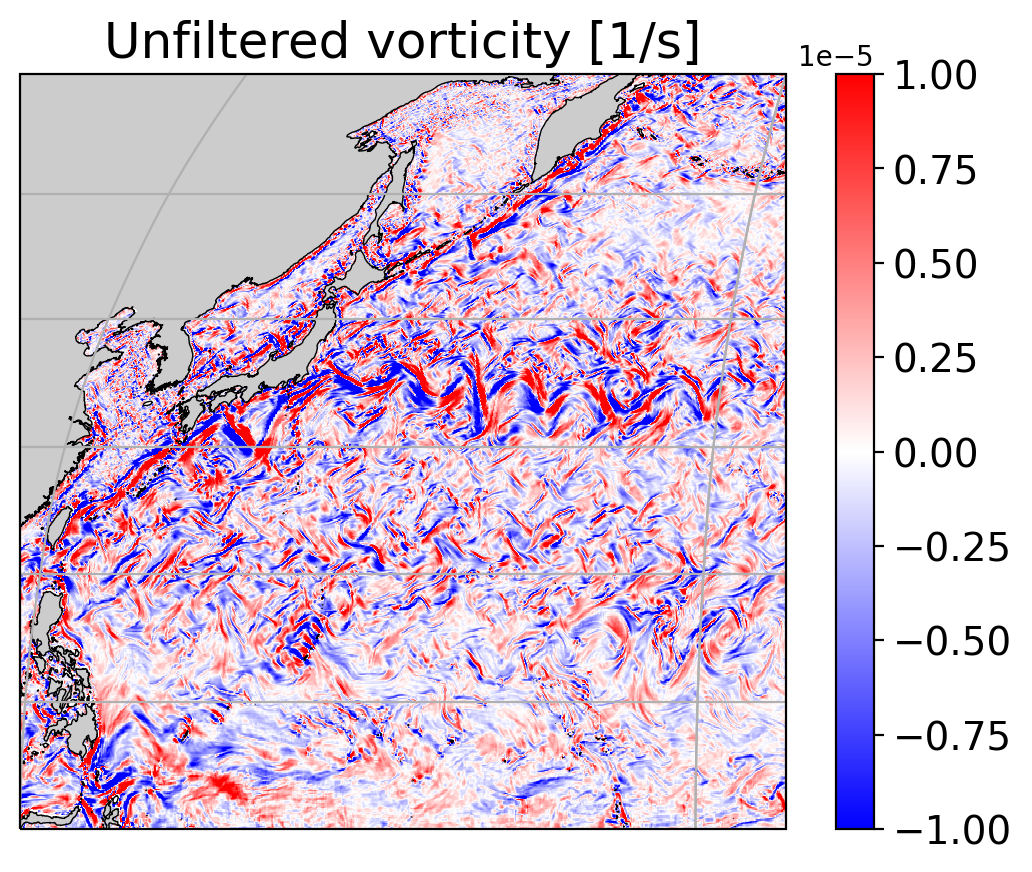

In [17]:
fig = plt.figure(figsize=(8, 5), dpi= 200, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
ax.set_extent([-240, -180, 0, 60],ccrs.PlateCarree())

ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[0.8, 0.8, 0.8])

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity,transform=ccrs.PlateCarree(),cmap='bwr',vmin=-1e-5,vmax=1e-5,shading='auto');

cbar=plt.colorbar(fraction=0.046, pad=0.04); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())

plt.title('Unfiltered vorticity [1/s]',fontsize=18)
plt.show()


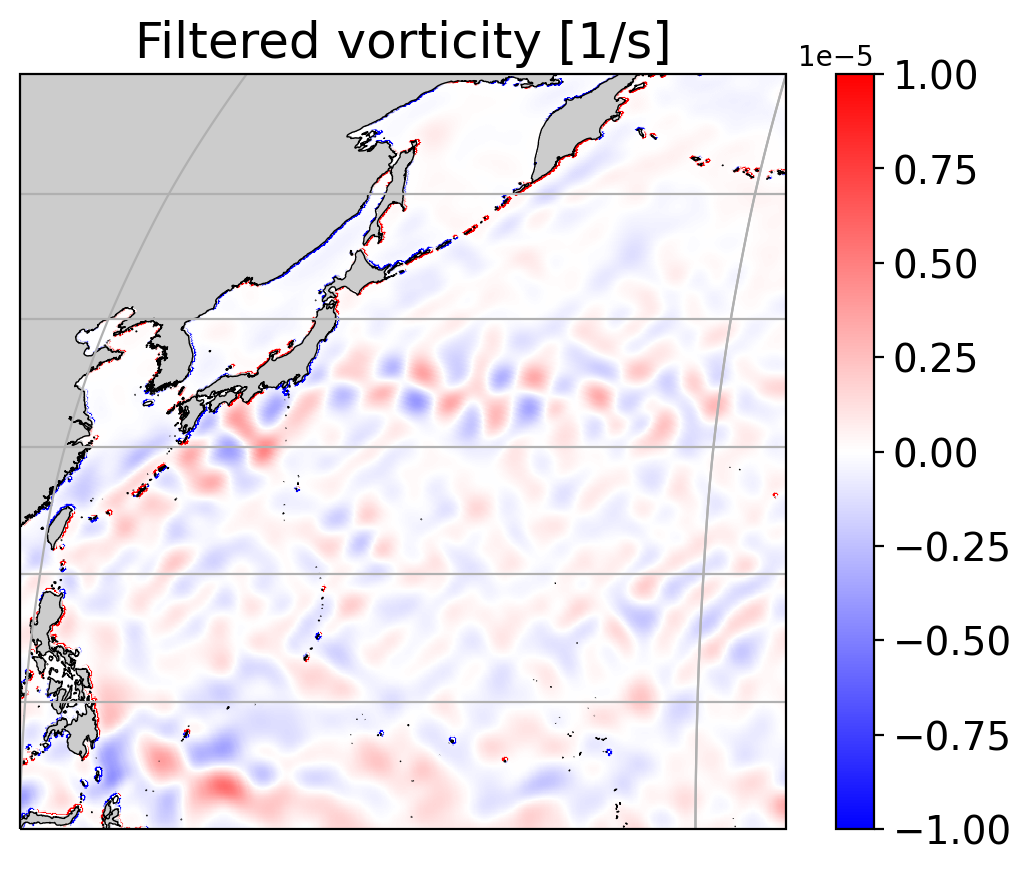

In [18]:
fig = plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
ax.set_extent([-240, -180, 0, 60],ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[0.8, 0.8, 0.8])

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],filtered_vorticity,transform=ccrs.PlateCarree(),cmap='bwr',vmin=-1e-5,vmax=1e-5,shading='auto');

cbar=plt.colorbar(fraction=0.046, pad=0.04); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())

plt.title('Filtered vorticity [1/s]',fontsize=18)
plt.show()



#### Now filtering the velocities and computing vorticity:

In [29]:
(u_filtered, v_filtered) = mom5_filterU.apply_to_vector(Cgrid_u, Cgrid_v, dims=['yh', 'xh'])
uv_filtered = xr.Dataset(dict(usurf=u_filtered, vsurf=v_filtered))
vorticity_filtereduv = compute_vorticity(uv_filtered, grid_data.isel(xt_ocean=slice(1,len(grid_data['xt_ocean'])),xu_ocean=slice(1,len(grid_data['xu_ocean'])),yt_ocean=slice(1,len(grid_data['yt_ocean'])),yu_ocean=slice(1,len(grid_data['yu_ocean'])))#, yu_ocean=[1:],xt_ocean=[1:], yt_ocean=[1:])
)

/home/eay8226/gcm-filters/gcm_filters/kernels.py:473: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/home/eay8226/gcm-filters/gcm_filters/kernels.py:474: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)
/home/eay8226/gcm-filters/gcm_filters/kernels.py:473: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/home/eay8226/gcm-filters/gcm_filters/kernels.py:474: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)


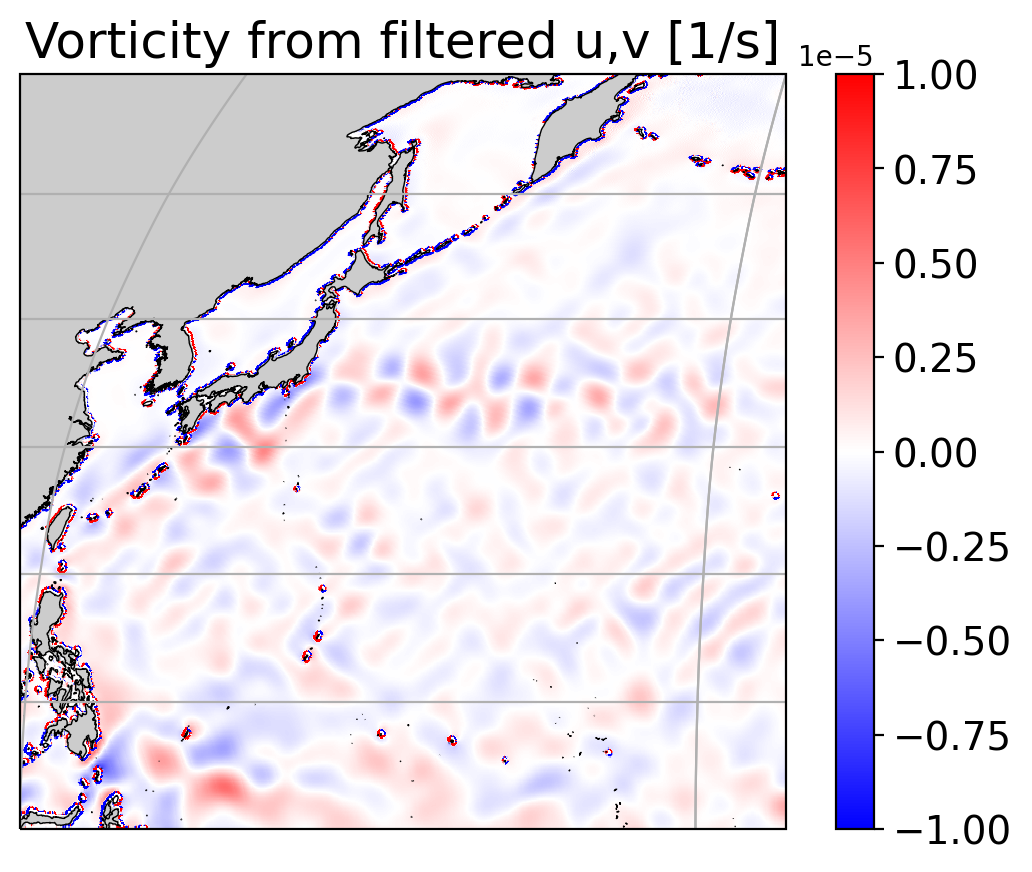

In [30]:
fig = plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
ax.set_extent([-240, -180, 0, 60],ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[0.8, 0.8, 0.8])

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],vorticity_filtereduv,transform=ccrs.PlateCarree(),cmap='bwr',vmin=-1e-5,vmax=1e-5,shading='auto');


cbar=plt.colorbar(fraction=0.046, pad=0.04); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())

plt.title('Vorticity from filtered u,v [1/s]',fontsize=18)
plt.show()


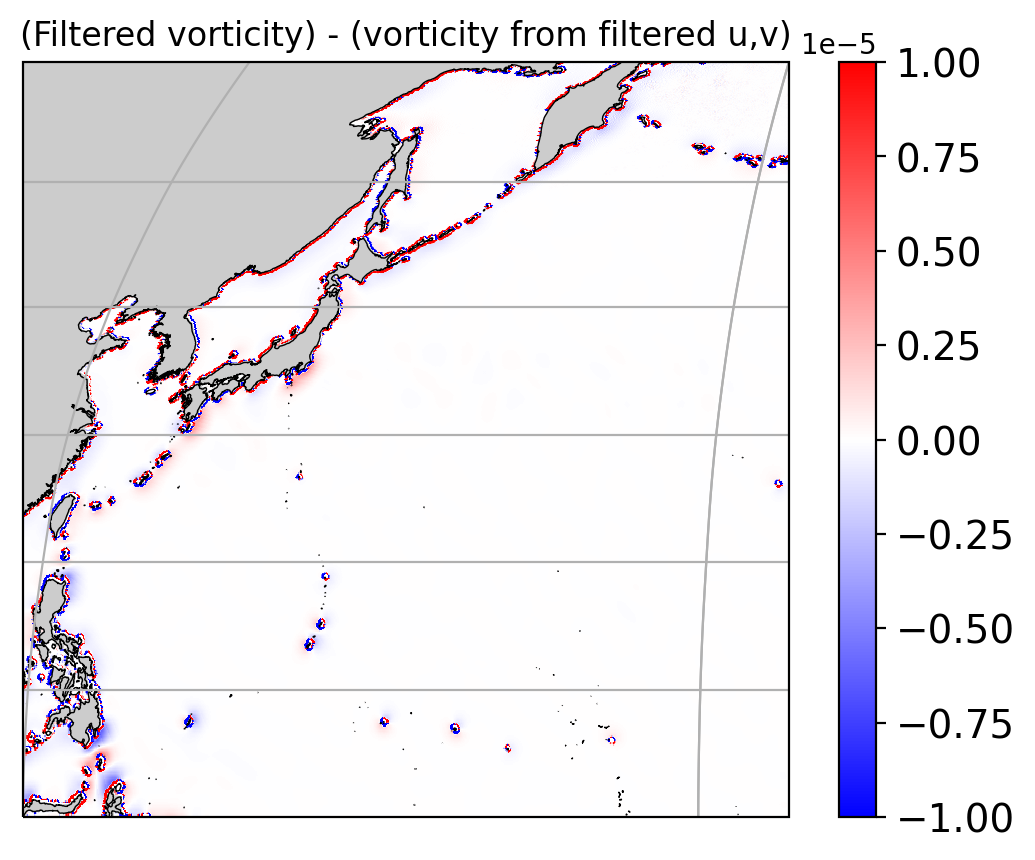

In [32]:
fig = plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
ax.set_extent([-240, -180, 0, 60],ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor=[0.8, 0.8, 0.8])

plt.pcolormesh(grid_dataT['xt_ocean'],grid_dataT['yt_ocean'],filtered_vorticity-vorticity_filtereduv,transform=ccrs.PlateCarree(),cmap='bwr',vmin=-1e-5,vmax=1e-5,shading='auto');


cbar=plt.colorbar(fraction=0.046, pad=0.04); cbar.ax.tick_params(labelsize=14);
gl=ax.gridlines(crs=ccrs.PlateCarree())

plt.title('(Filtered vorticity) - (vorticity from filtered u,v)',fontsize=12)
plt.show()
